In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import glob

# Set the input image dimensions (e.g., 256x256)
img_height, img_width = 256, 256
input_channels = 3  # Multispectral bands (RGB)
output_channels = 25  # Hyperspectral bands

# Folder structure for your dataset
data_dir = 'C:/Users/ENLSFT032DT/Downloads/Multispectral_input'


# Function to load images
def load_images_from_folder(folder, img_height, img_width):
    images = []
    for filename in glob.glob(os.path.join(folder, "*.tif")):
        img = load_img(filename, target_size=(img_height, img_width))
        img = img_to_array(img)
        images.append(img)
    return np.array(images)

# Load all images from subfolders
def load_dataset(data_dir, img_height, img_width):
    all_images = []
    for subdir in os.listdir(data_dir):
        subdir_path = os.path.join(data_dir, subdir)
        if os.path.isdir(subdir_path):
            images = load_images_from_folder(subdir_path, img_height, img_width)
            all_images.append(images)
    return np.vstack(all_images)

# Load the dataset
X_train = load_dataset(data_dir, img_height, img_width)

# Reshape the dataset to include a depth dimension (for Conv3D: (height, width, depth, 1))
X_train = X_train.reshape((-1, img_height, img_width, input_channels, 1))

# Normalize the images (scale to [0, 1])
X_train = X_train / 255.0

# Define the neural network architecture using Conv3D
def build_model(input_channels, output_channels, img_height, img_width):
    model = models.Sequential()
    
    # Input layer
    model.add(layers.InputLayer(input_shape=(img_height, img_width, input_channels, 1)))
    
    # Intermediate layers: gradually increasing channels to 25
    model.add(layers.Conv3D(8, (3, 3, 3), activation='relu', padding='same'))
    model.add(layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same'))
    model.add(layers.Conv3D(25, (3, 3, 3), activation='relu', padding='same'))
    
    # Output layer: ensuring the number of channels is 25
    model.add(layers.Conv3D(output_channels, (3, 3, 3), activation='sigmoid', padding='same'))
    
    return model

# Build the model
model = build_model(input_channels, output_channels, img_height, img_width)

# Compile the model with MSE loss for all 25 bands
def custom_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))  # Compare all channels, not just the first 3

model.compile(optimizer='adam', loss=custom_loss)

# Summary of the model
model.summary()

# Train the model
history = model.fit(X_train, X_train, epochs=20, batch_size=16, validation_split=0.1)

# Save the model for future use
model.save('hyperspectral_model_3d_mse_all_bands.h5')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 256, 256, 3, 8)    224       
                                                                 
 conv3d_1 (Conv3D)           (None, 256, 256, 3, 16)   3472      
                                                                 
 conv3d_2 (Conv3D)           (None, 256, 256, 3, 25)   10825     
                                                                 
 conv3d_3 (Conv3D)           (None, 256, 256, 3, 25)   16900     
                                                                 
Total params: 31421 (122.74 KB)
Trainable params: 31421 (122.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
29/29 [==============================] - 350s 12s/step - loss: 0.0298 - val_loss: 0.0418
Epoch 2/20
29/29 [==============================] 

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
import os
import numpy as np
import glob
from shutil import copy2

# Set the data directory and image dimensions
data_dir = 'C:/Users/ENLSFT032DT/Downloads/Multispectral_input'  # Original folder with all images
train_images_folder = 'C:/Users/ENLSFT032DT/Downloads/training_images'  # Folder to store training images
val_images_folder = 'C:/Users/ENLSFT032DT/Downloads/validation_images'  # Folder to store validation images

# Set validation split ratio
validation_split = 0.1

# Function to split images into training and validation sets and save them in separate folders
def split_train_val(data_dir, train_images_folder, val_images_folder, validation_split=0.1):
    # Get all image file paths recursively (including subdirectories)
    image_paths = glob.glob(os.path.join(data_dir, "**", "*.tif"), recursive=True)
    
    if len(image_paths) == 0:
        print("No images found in the specified directory. Please check the path and image file types.")
        return

    total_images = len(image_paths)
    
    # Calculate number of validation images
    val_size = int(total_images * validation_split)
    
    # Create folders if they don't exist
    os.makedirs(train_images_folder, exist_ok=True)
    os.makedirs(val_images_folder, exist_ok=True)
    
    # Shuffle the image list
    np.random.shuffle(image_paths)
    
    # Split into training and validation sets
    val_images = image_paths[:val_size]
    train_images = image_paths[val_size:]
    
    # Copy training images to the new folder
    for image_path in train_images:
        copy2(image_path, train_images_folder)
    
    # Copy validation images to the new folder
    for image_path in val_images:
        copy2(image_path, val_images_folder)
    
    print(f"Training images: {len(train_images)}")
    print(f"Validation images: {len(val_images)}")

# Split the dataset into training and validation sets and store them separately
split_train_val(data_dir, train_images_folder, val_images_folder, validation_split=validation_split)


Training images: 450
Validation images: 50


In [10]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import glob

# Define the custom loss function (same as used during model training)
def custom_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))  # Compare all channels, not just the first 3

# Load the trained 3D Conv model with the custom loss function
model = load_model('hyperspectral_model_3d_mse_all_bands.h5', custom_objects={'custom_loss': custom_loss})

# Function to load and preprocess a multispectral image
def load_multispectral_image(image_path, img_height, img_width):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    
    # Reshape to add the required Conv3D dimensions: (height, width, channels, 1)
    img = img.reshape((1, img_height, img_width, img.shape[2], 1))
    img = img / 255.0  # Normalize the image to [0, 1]
    return img

# Function to save the full 25-band hyperspectral image as a NumPy array
def save_hyperspectral_image_numpy(predicted_image, output_folder, base_name):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Reshape the predicted image into (256, 256, 3, 25) -> (256, 256, 3, 25)
    combined_image = predicted_image  # Shape: (256, 256, 3, 25)

    # Save the combined 25-band image as a .npy file (NumPy array)
    np.save(os.path.join(output_folder, f'{base_name}_25_band_hyperspectral.npy'), combined_image)

# Set image dimensions
img_height, img_width = 256, 256

# Folder where the training images are stored
train_images_folder = 'C:/Users/ENLSFT032DT/Downloads/training_images'   # Set this to your training images folder

# Output folder where predicted 25-band hyperspectral images will be saved
output_folder = 'C:/Users/ENLSFT032DT/Downloads/predicted_hyperspectral_images'

# Loop through all the training images and process them
for image_path in glob.glob(os.path.join(train_images_folder, "*.tif")):
    # Load each multispectral image
    multispectral_image = load_multispectral_image(image_path, img_height, img_width)

    # Make a prediction for the hyperspectral image (25 bands)
    predicted_hyperspectral_image = model.predict(multispectral_image)

    # Extract the base name of the image to use for saving the file
    base_name = os.path.splitext(os.path.basename(image_path))[0]

    # Save the full 25-band hyperspectral image as a .npy file
    save_hyperspectral_image_numpy(predicted_hyperspectral_image[0], output_folder, base_name)


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 70ms/step


Hyperspectral image shape: (256, 256, 3, 25)


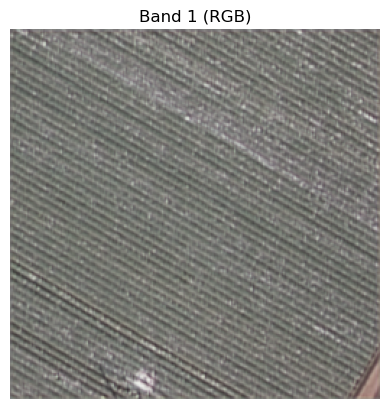

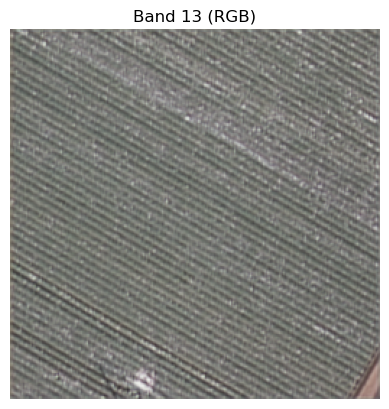

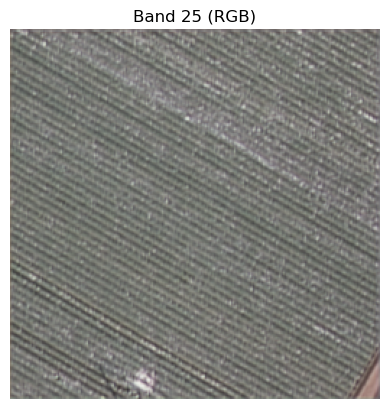

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the .npy file containing the 25-band hyperspectral image
npy_file_path ='C:/Users/ENLSFT032DT/Downloads/agricultural01_25_band_hyperspectral.npy'  # Set this to your .npy file path
hyperspectral_image = np.load(npy_file_path)

# Check the shape of the loaded hyperspectral image
print(f"Hyperspectral image shape: {hyperspectral_image.shape}")  # Should be (256, 256, 3, 25)

# Function to visualize a specific band
def visualize_band(hyperspectral_image, band_index):
    # Extract the specific band (which contains RGB values)
    band_image = hyperspectral_image[:, :, :, band_index]

    # Normalize the band image to the range [0, 255]
    band_image = (band_image * 255).astype(np.uint8)

    # Convert the NumPy array to a PIL image for display
    band_image_pil = Image.fromarray(band_image, 'RGB')

    # Display the band
    plt.imshow(band_image_pil)
    plt.title(f'Band {band_index + 1} (RGB)')
    plt.axis('off')
    plt.show()

# Example: Visualize the first, middle, and last bands (RGB)
visualize_band(hyperspectral_image, 0)   # First band
visualize_band(hyperspectral_image, 12)  # Middle band
visualize_band(hyperspectral_image, 24)  # Last band (25th)


In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Folder where the .npy files are stored
npy_folder = 'C:/Users/ENLSFT032DT/Downloads/predicted_hyperspectral_images'  # Update with your .npy files folder
output_folder = 'C:/Users/ENLSFT032DT/Downloads/converted_png_images'  # Output folder to save .png files

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Function to save each band of the hyperspectral image as an RGB PNG file
def save_all_bands_as_png(hyperspectral_image, base_name, output_folder):
    # Iterate through all 25 bands
    for band_index in range(hyperspectral_image.shape[-1]):
        # Extract the specific band (which contains RGB values)
        band_image = hyperspectral_image[:, :, :, band_index]

        # Normalize the band image to the range [0, 255]
        band_image = (band_image * 255).astype(np.uint8)

        # Convert the NumPy array to a PIL image for saving
        band_image_pil = Image.fromarray(band_image, 'RGB')

        # Save the band as a PNG file
        band_image_pil.save(os.path.join(output_folder, f'{base_name}_band_{band_index + 1}.png'))

# Loop through all the .npy files in the folder
for npy_file in os.listdir(npy_folder):
    if npy_file.endswith('.npy'):
        # Load the .npy file
        npy_file_path = os.path.join(npy_folder, npy_file)
        hyperspectral_image = np.load(npy_file_path)

        # Extract the base name of the file (without the .npy extension)
        base_name = os.path.splitext(npy_file)[0]

        # Save all 25 bands of the hyperspectral image as PNG files
        save_all_bands_as_png(hyperspectral_image, base_name, output_folder)

print("Conversion complete! All images are saved as PNG files.")


Conversion complete! All images are saved as PNG files.
